In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
# branch_defs = [
#     (("X", "O", "Q"), 0.5, 1),
#     (("X",), 0, 0.5),
#     (("O", "Q"), 0.35, 0.5),
#     (("O",), 0, 0.35),
#     (("Q",), 0, 0.35)
# ]
branch_defs = [(tuple(classes), 0, 1)]

In [4]:
class LetterDataset(torch.utils.data.Dataset):
    def __init__(self):
        data_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/letter_recognition/letter-recognition.data"
        
        data = []
        targets = []
        with open(data_path, "r") as f:
            for line in f:
                tokens = line.strip().split(",")
                targets.append(tokens[0])
                data.append(np.array(list(map(int, tokens[1:]))))
        self.data = np.stack(data)
        self.targets = np.array(targets)
        self.target_inds = np.unique(self.targets, return_inverse=True)[1]
        
        # Center/normalize the data
        self.data = (self.data - np.mean(self.data, axis=0, keepdims=True)) / \
            np.std(self.data, axis=0, keepdims=True)
        
    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), self.targets[index]
        
    def __len__(self):
        return len(self.targets)
    
dataset = LetterDataset()

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]
dataset.target_inds = dataset.target_inds[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [6]:
class MLP(torch.nn.Module):
    def __init__(
        self, input_dim, num_layers=4, hidden_dims=([256] * 3), time_embed_std=30,
        embed_size=256, t_limit=1
    ):
        super().__init__()
        self.creation_args = {}
        
        self.t_limit = t_limit
        assert embed_size % 2 == 0
        
        self.time_embed_rand_weights = torch.nn.Parameter(
            torch.randn(embed_size // 2) * time_embed_std,
            requires_grad=False
        )
        
        self.time_dense_1 = torch.nn.Linear(embed_size, embed_size)
        self.time_dense_2 = torch.nn.Linear(embed_size, embed_size)
        self.input_dense = torch.nn.Linear(input_dim, embed_size)
        
        self.dense_layers = torch.nn.ModuleList()
        for i in range(num_layers):
            if i == 0:
                dense_layer = torch.nn.Linear(embed_size, hidden_dims[i])
            elif i < num_layers - 1:
                dense_layer = torch.nn.Linear(hidden_dims[i - 1], hidden_dims[i])
            else:
                dense_layer = torch.nn.Linear(hidden_dims[i - 1], input_dim)
            self.dense_layers.append(dense_layer)
            
        self.swish = lambda x: x * torch.sigmoid(x)
        self.relu = torch.nn.ReLU()
        self.mse = torch.nn.MSELoss()
        
    def forward(self, xt, t, task_inds=None):
        time_embed_args = (t[:, None] / self.t_limit) * (2 * np.pi) * self.time_embed_rand_weights[None, :]
        # Shape: B x E
        time_embed = self.time_dense_2(self.swish(self.time_dense_1(
            torch.cat([
                torch.sin(time_embed_args), torch.cos(time_embed_args)
            ], dim=1)
        )))
        # Shape: B x E
        
        x = self.input_dense(xt) + time_embed
                
        for i in range(len(self.dense_layers)):
            x = self.dense_layers[i](x)
            if i < len(self.dense_layers) - 1:
                x = self.relu(x)
                
        return x[:, None]
    
    def loss(self, pred_vals, true_vals, task_inds, weights=None):
        return self.mse(pred_vals[:, 0], true_vals)

In [7]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 1, input_shape)

t_limit = 1
model = MLP(
    input_shape[0], t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/misc"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

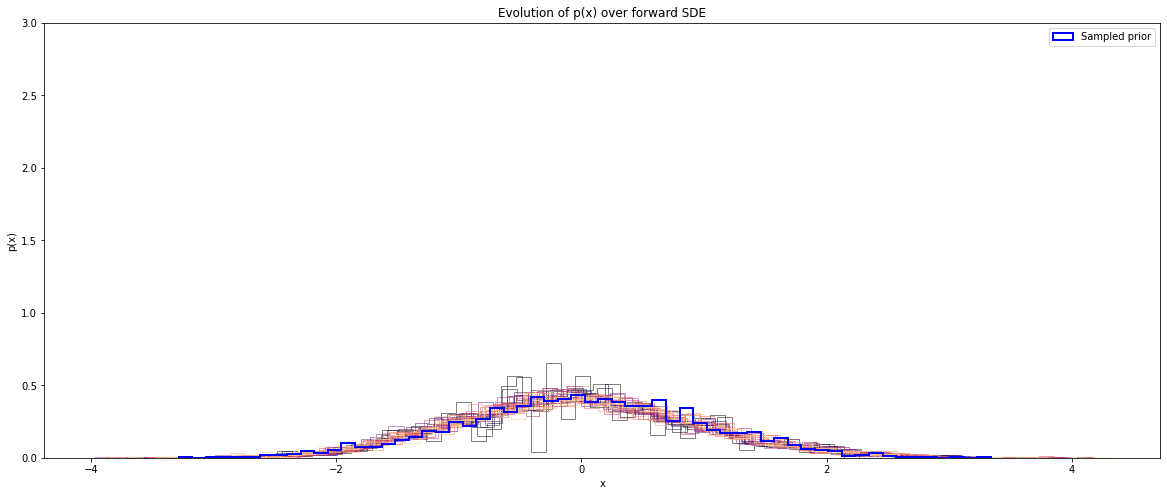

In [8]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [9]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 100,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "27"
Loss: 17.24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 57.50it/s]


Epoch 1 average Loss: 82.14


Loss: 41.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.30it/s]


Epoch 2 average Loss: 70.32


Loss: 188.51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.36it/s]


Epoch 3 average Loss: 179.94


Loss: 11.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.79it/s]


Epoch 4 average Loss: 91.55


Loss: 51.29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 66.08it/s]


Epoch 5 average Loss: 72.13


Loss: 22.60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.95it/s]


Epoch 6 average Loss: 194.19


Loss: 8.70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.85it/s]


Epoch 7 average Loss: 117.81


Loss: 85.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.11it/s]


Epoch 8 average Loss: 59.30


Loss: 24.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.60it/s]


Epoch 9 average Loss: 173.80


Loss: 19.22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 66.70it/s]


Epoch 10 average Loss: 93.59


Loss: 10.31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.33it/s]


Epoch 11 average Loss: 67.64


Loss: 39.53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 66.80it/s]


Epoch 12 average Loss: 93.69


Loss: 30.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.55it/s]


Epoch 13 average Loss: 110.63


Loss: 40.41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 66.17it/s]


Epoch 14 average Loss: 73.29


Loss: 61.50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.09it/s]


Epoch 15 average Loss: 75.59


Loss: 17.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.78it/s]


Epoch 16 average Loss: 100.27


Loss: 122.75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.77it/s]


Epoch 17 average Loss: 92.26


Loss: 43.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.82it/s]


Epoch 18 average Loss: 105.17


Loss: 38.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.17it/s]


Epoch 19 average Loss: 78.35


Loss: 18.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.36it/s]


Epoch 20 average Loss: 124.58


Loss: 14.57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.53it/s]


Epoch 21 average Loss: 249.11


Loss: 53.44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.53it/s]


Epoch 22 average Loss: 77.84


Loss: 156.58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.49it/s]


Epoch 23 average Loss: 72.93


Loss: 86.33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.93it/s]


Epoch 24 average Loss: 86.03


Loss: 43.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.50it/s]


Epoch 25 average Loss: 124.79


Loss: 2305.22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.40it/s]


Epoch 26 average Loss: 94.25


Loss: 93.15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.92it/s]


Epoch 27 average Loss: 132.48


Loss: 36.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.00it/s]


Epoch 28 average Loss: 81.48


Loss: 30.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.18it/s]


Epoch 29 average Loss: 68.18


Loss: 23.55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.18it/s]


Epoch 30 average Loss: 99.53


Loss: 57.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.91it/s]


Epoch 31 average Loss: 86.93


Loss: 75.68: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.49it/s]


Epoch 32 average Loss: 79.23


Loss: 71.24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.34it/s]


Epoch 33 average Loss: 75.79


Loss: 7.03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.63it/s]


Epoch 34 average Loss: 78.07


Loss: 21.67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.34it/s]


Epoch 35 average Loss: 176.45


Loss: 72.80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.38it/s]


Epoch 36 average Loss: 246.05


Loss: 21.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.65it/s]


Epoch 37 average Loss: 67.74


Loss: 14.55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 61.87it/s]


Epoch 38 average Loss: 378.82


Loss: 22.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.66it/s]


Epoch 39 average Loss: 120.49


Loss: 53.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.69it/s]


Epoch 40 average Loss: 127.72


Loss: 86.88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.00it/s]


Epoch 41 average Loss: 82.03


Loss: 40.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.35it/s]


Epoch 42 average Loss: 72.77


Loss: 28.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.24it/s]


Epoch 43 average Loss: 92.83


Loss: 8.18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.76it/s]


Epoch 44 average Loss: 62.21


Loss: 34.18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.79it/s]


Epoch 45 average Loss: 227.08


Loss: 98.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.09it/s]


Epoch 46 average Loss: 121.16


Loss: 54.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.47it/s]


Epoch 47 average Loss: 78.58


Loss: 22.48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.81it/s]


Epoch 48 average Loss: 527.32


Loss: 36.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.30it/s]


Epoch 49 average Loss: 112.46


Loss: 18.73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.36it/s]


Epoch 50 average Loss: 116.74


Loss: 80.39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.24it/s]


Epoch 51 average Loss: 134.42


Loss: 8.01: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.40it/s]


Epoch 52 average Loss: 94.50


Loss: 39.50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.13it/s]


Epoch 53 average Loss: 98.17


Loss: 13.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.78it/s]


Epoch 54 average Loss: 121.46


Loss: 146.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 62.90it/s]


Epoch 55 average Loss: 128.85


Loss: 29.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.30it/s]


Epoch 56 average Loss: 171.87


Loss: 116.41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.61it/s]


Epoch 57 average Loss: 70.25


Loss: 24.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.08it/s]


Epoch 58 average Loss: 85.55


Loss: 196.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.72it/s]


Epoch 59 average Loss: 106.68


Loss: 19.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.84it/s]


Epoch 60 average Loss: 67.03


Loss: 73966.32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.09it/s]


Epoch 61 average Loss: 587.12


Loss: 479.08: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.68it/s]


Epoch 62 average Loss: 240.48


Loss: 51.55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.05it/s]


Epoch 63 average Loss: 104.10


Loss: 28.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.67it/s]


Epoch 64 average Loss: 89.96


Loss: 27.34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.43it/s]


Epoch 65 average Loss: 128.42


Loss: 8.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.43it/s]


Epoch 66 average Loss: 67.02


Loss: 32.81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.49it/s]


Epoch 67 average Loss: 139.07


Loss: 32.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.85it/s]


Epoch 68 average Loss: 100.18


Loss: 48.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.59it/s]


Epoch 69 average Loss: 72.82


Loss: 21.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.31it/s]


Epoch 70 average Loss: 88.32


Loss: 18.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.26it/s]


Epoch 71 average Loss: 110.57


Loss: 63.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.69it/s]


Epoch 72 average Loss: 183.45


Loss: 13.70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.27it/s]


Epoch 73 average Loss: 338.13


Loss: 93.40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.72it/s]


Epoch 74 average Loss: 86.70


Loss: 22.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.09it/s]


Epoch 75 average Loss: 92.50


Loss: 10.53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.69it/s]


Epoch 76 average Loss: 78.43


Loss: 9.82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.20it/s]


Epoch 77 average Loss: 149.70


Loss: 30.51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.17it/s]


Epoch 78 average Loss: 89.84


Loss: 144.50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.11it/s]


Epoch 79 average Loss: 68.39


Loss: 12.25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.23it/s]


Epoch 80 average Loss: 86.31


Loss: 15.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.45it/s]


Epoch 81 average Loss: 86.47


Loss: 13.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.17it/s]


Epoch 82 average Loss: 77.98


Loss: 269.56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.15it/s]


Epoch 83 average Loss: 79.14


Loss: 173.30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.54it/s]


Epoch 84 average Loss: 85.66


Loss: 18.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.30it/s]


Epoch 85 average Loss: 73.94


Loss: 39.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.29it/s]


Epoch 86 average Loss: 143.51


Loss: 34.32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 62.73it/s]


Epoch 87 average Loss: 191.27


Loss: 21.66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.75it/s]


Epoch 88 average Loss: 62.47


Loss: 10.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.62it/s]


Epoch 89 average Loss: 73.93


Loss: 33.80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.96it/s]


Epoch 90 average Loss: 68.26


Loss: 52.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.59it/s]


Epoch 91 average Loss: 91.16


Loss: 26.58: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 66.12it/s]


Epoch 92 average Loss: 130.51


Loss: 19.74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.50it/s]


Epoch 93 average Loss: 115.88


Loss: 25.49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.69it/s]


Epoch 94 average Loss: 77.78


Loss: 28.04: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.14it/s]


Epoch 95 average Loss: 95.24


Loss: 25.92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.61it/s]


Epoch 96 average Loss: 69.59


Loss: 10.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 65.16it/s]


Epoch 97 average Loss: 150.12


Loss: 13.96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 63.93it/s]


Epoch 98 average Loss: 75.14


Loss: 323.71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 62.13it/s]


Epoch 99 average Loss: 241.13


Loss: 48.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 64.92it/s]
INFO - train - Completed after 0:04:05


Epoch 100 average Loss: 78.82


### Show generated distributions

In [10]:
samples = generate.generate_continuous_branched_samples(
    model, sde, 0, lambda x, y: torch.zeros_like(x),
    sampler="pc", t_limit=t_limit
)
samples = samples.cpu().numpy()

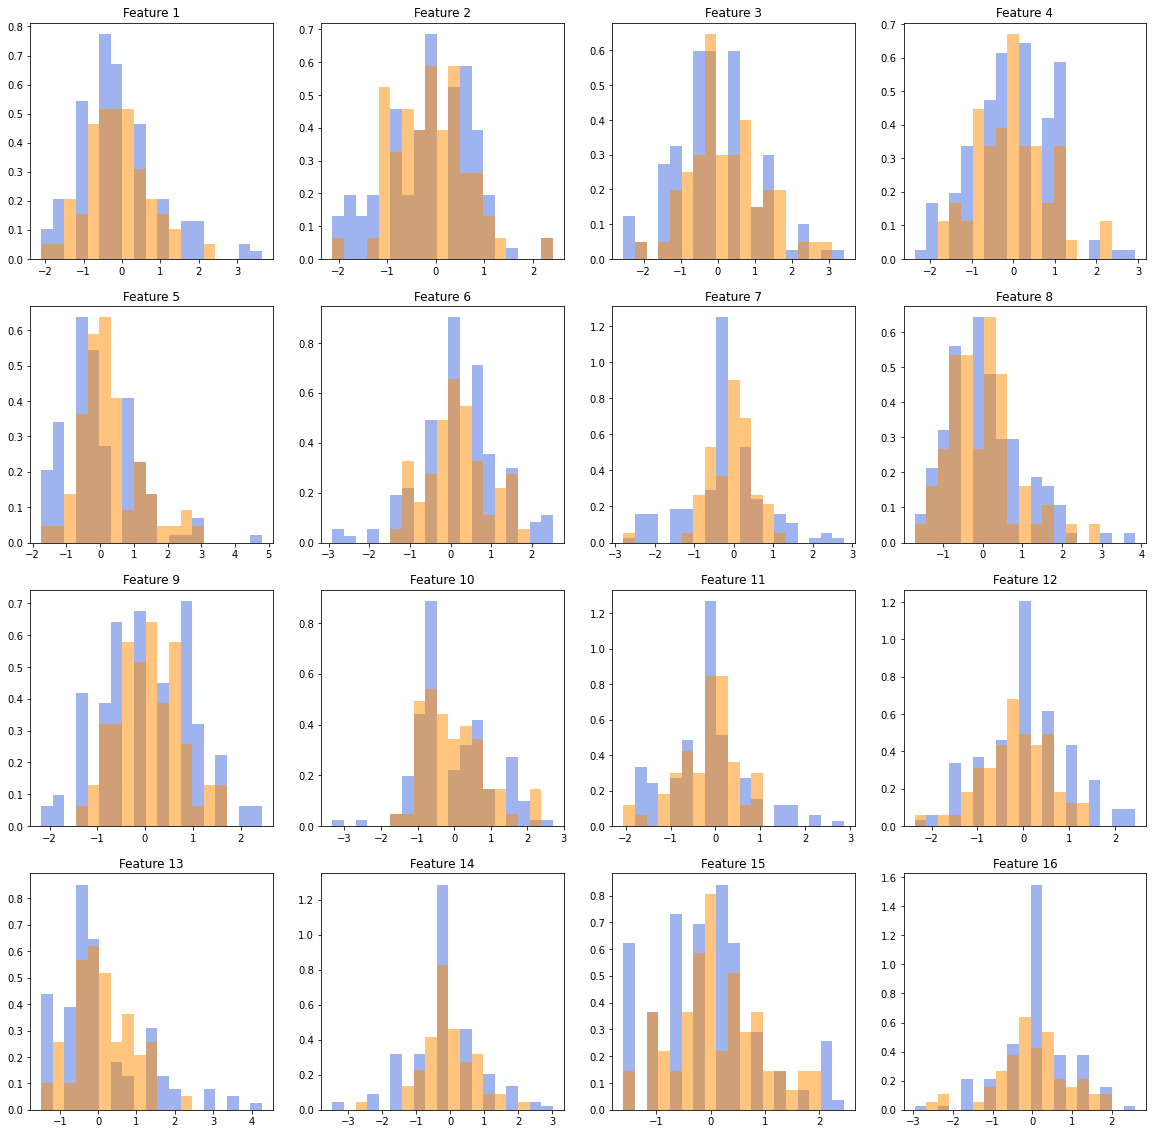

In [11]:
real = next(iter(data_loader))[0].numpy()

num_features = input_shape[0]
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20

fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
for i in range(num_features):
    r, c = i // num_cols, i % num_cols
    real_vals = real[:, i]
    sample_vals = samples[:, i]
    all_vals = np.concatenate([real_vals, sample_vals])
    bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
    ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
    ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
    ax[r][c].set_title("Feature %d" % (i + 1))
plt.show()

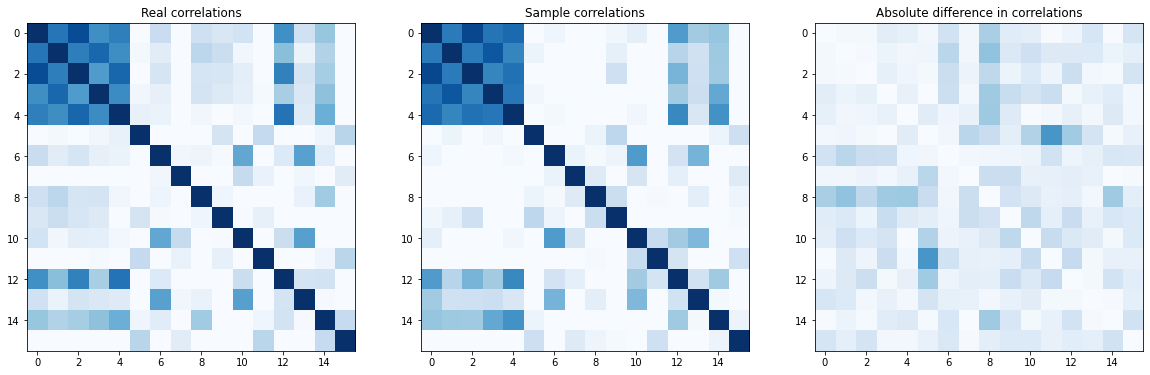

In [12]:
real_corrs = np.empty((num_features, num_features))
sample_corrs = np.empty_like(real_corrs)
for i in range(num_features):
    real_corrs[i, i] = 1
    sample_corrs[i, i] = 1
    for j in range(i):
        real_corrs[i, j] = scipy.stats.pearsonr(real[:, i], real[:, j])[0]
        real_corrs[j, i] = real_corrs[i, j]
        sample_corrs[i, j] = scipy.stats.pearsonr(samples[:, i], samples[:, j])[0]
        sample_corrs[j, i] = sample_corrs[i, j]
        
fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
ax[0].set_title("Real correlations")
ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
ax[1].set_title("Sample correlations")
ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
ax[2].set_title("Absolute difference in correlations")
plt.show()

**Diffusing from one class to another**

In [13]:
# orig_4 = torch.stack([
#     torch.tensor(dataset[i][0], device=DEVICE) for i in 
#     np.random.choice(np.where(dataset.targets == 4)[0], size=32, replace=False)
# ])
# orig_9 = torch.stack([
#     torch.tensor(dataset[i][0], device=DEVICE) for i in 
#     np.random.choice(np.where(dataset.targets == 9)[0], size=32, replace=False)
# ])

# time_steps = 10
# all_t = np.linspace(0, branch_time_4_9, time_steps)
# forward_4_to_9 = np.empty((len(all_t),) + orig_4.shape)
# backward_4_to_9 = np.empty((len(all_t) - 1,) + orig_4.shape)
# forward_9_to_4 = np.empty((len(all_t),) + orig_4.shape)
# backward_9_to_4 = np.empty((len(all_t) - 1,) + orig_4.shape)
# orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)
# for t_i, t in enumerate(all_t):
#     forward_4_to_9[t_i] = sde.forward(
#         orig_4_tens, torch.ones(len(orig_4_tens)).to(DEVICE) * t
#     )[0].cpu().numpy()
#     forward_9_to_4[t_i] = sde.forward(
#         orig_9_tens, torch.ones(len(orig_9_tens)).to(DEVICE) * t
#     )[0].cpu().numpy()

# all_t_flip = np.flip(all_t)
# last_4_to_9 = torch.tensor(forward_4_to_9[-1]).to(DEVICE).float()
# last_9_to_4 = torch.tensor(forward_9_to_4[-1]).to(DEVICE).float()
# for t_i in range(len(all_t_flip) - 1):
#     last_4_to_9 = generate.generate_continuous_branched_samples(
#         model, sde, 9, class_time_to_branch_tensor, sampler="pc",
#         t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
#         num_samples=orig_4.shape[0], initial_samples=last_4_to_9,
#         num_steps=50
#     )
#     backward_4_to_9[t_i] = last_4_to_9.cpu().numpy()
    
#     last_9_to_4 = generate.generate_continuous_branched_samples(
#         model, sde, 4, class_time_to_branch_tensor, sampler="pc",
#         t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
#         num_samples=orig_9.shape[0], initial_samples=last_9_to_4,
#         num_steps=50
#     )
#     backward_9_to_4[t_i] = last_9_to_4.cpu().numpy()
    
# print("4 to 9")
# for t_i, t in enumerate(all_t):
#     plot_mnist_digits(forward_4_to_9[t_i], title=("%.2f" % t))
# for t_i, t in enumerate(all_t_flip[1:]):
#     plot_mnist_digits(backward_4_to_9[t_i], title=("%.2f" % t))

# print("9 to 4")
# for t_i, t in enumerate(all_t):
#     plot_mnist_digits(forward_9_to_4[t_i], title=("%.2f" % t))
# for t_i, t in enumerate(all_t_flip[1:]):
#     plot_mnist_digits(backward_9_to_4[t_i], title=("%.2f" % t))